# COMP0005 - GROUP COURSEWORK 2023-24
# Gesture Recognition via Convex Hull 

Use the cell below for all python code needed to realise the **Jarvis march algorithm** (including auxiliary data structures and functions needed by this algorithm - if any). The `jarvismarch()` function itself should take as input parameter a list of 2D points (`inputSet`), and return the subset of such points (`outputSet`) that lie on the convex hull.

In [1]:
import math

def jarvismarch(inputSet):
    '''
    Returns the list of points that lie on the convex hull (jarvis march algorithm)
            Parameters:
                    inputSet (list): a list of 2D points

            Returns:
                    outputSet (list): a list of 2D points
    '''

    #ADD YOUR CODE HERE
    for coords in inputSet:
        pass

    return outputSet

Use the cell below for all python code needed to realise the **Graham scan** algorithm (including auxiliary data structures and functions needed by this algorithm - if any). The `grahamscan()` function itself should take as input parameter a list of 2D points (`inputSet`), and return the subset of such points that lie on the convex hull (`outputSet`).

In [2]:
def grahamscan(inputSet):
    '''
    Returns the list of points that lie on the convex hull (graham scan algorithm)
            Parameters:
                    inputSet (list): a list of 2D points

            Returns:
                    outputSet (list): a list of 2D points
    '''

    #ADD YOUR CODE HERE

    return outputSet

Use the cell below for all python code needed to realise the **Chen's** algorithm (including auxiliary data structures and functions needed by this algorithm - if any). The `chen()` function itself should take as input parameter a list of 2D points (`inputSet`), and return the subset of such points that lie on the convex hull (`outputSet`).

In [3]:
def chen(inputSet):
    '''
    Returns the list of points that lie on the convex hull (chen's algorithm)
            Parameters:
                    inputSet (list): a list of 2D points

            Returns:
                    outputSet (list): a list of 2D points
    '''

    #ADD YOUR CODE HERE


    return outputSet

Use the cell below to implement the **synthetic data generator** needed by your experimental framework (including any auxiliary data structures and functions you might need - be mindful of code readability and reusability).

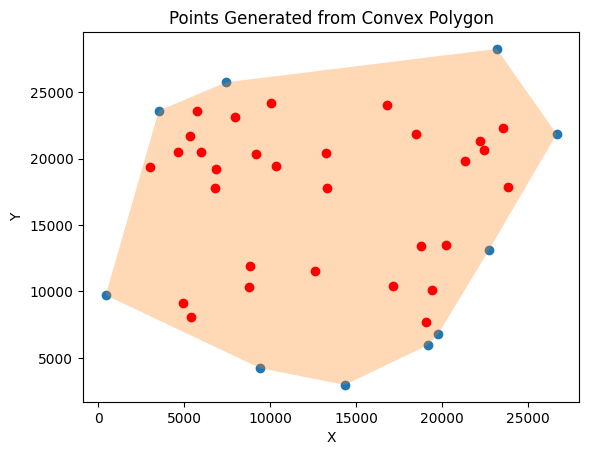

In [76]:
import random
import math

class TestDataGenerator():
    """
    A class to represent a synthetic data generator.

    ...

    Attributes
    ----------
    
    [to be defined as part of the coursework]

    Methods
    -------
    
    [to be defined as part of the coursework]

    """

    
        
    def __init__(self, n, h):
        self.n = n
        self.h = h
        self.scale = 32767
        self.convexHull = self.generateConvexPolygon()
        self.points = self.generatePointsInside()


    def generatePointsInside(self):
        count = self.h
        points = self.convexHull.copy()

        while count < self.n:
            xPoint = random.randint(0, self.scale)
            yPoint = random.randint(0, self.scale)

            if self.isInsidePoly(xPoint, yPoint):
                points.append((xPoint, yPoint))
                count += 1

        return points

    def isInsidePoly(self, xPoint, yPoint):
        inside = False

        p1x, p1y = self.convexHull[0]
        for i in range(self.h + 1):
            p2x, p2y = self.convexHull[i % self.h]
            if yPoint > min(p1y, p2y) and yPoint <= max(p1y, p2y):
                if xPoint <= max(p1x, p2x):
                    if p1y != p2y:
                        xintersection = (yPoint - p1y) * (p2x - p1x) / (p2y - p1y) + p1x #Ray tracing formula
                    if p1x == p2x or xPoint <= xintersection:
                        inside = not inside
        
            p1x, p1y = p2x, p2y

        return inside 


    def generateConvexPolygon(self):
        # Credit to Pavel Valtr for convex polygon algorithm design

        ''' 
        Starting from a convex polygon allows specfying h value.
        Valtr's algorithm allows random polygons in a square domain unlike circumcircle method. 
        '''

        xs = []
        ys = []
        for _ in range(self.h):
            xs.append(random.randint(0, self.scale))
            ys.append(random.randint(0, self.scale))
            
        xs.sort()
        ys.sort()
        min_x, *xs, max_x = xs
        min_y, *ys, max_y = ys
        
        xVector = self.makeVectors(xs, min_x, max_x)
        yVector = self.makeVectors(ys, min_y, max_y)
        random.shuffle(yVector)

        vectors = sorted(zip(xVector, yVector), key=self.vectorAngle)
        xPoint = yPoint = 0
        poly_x_min = poly_y_min = 0 
        points = []

        for xVector, yVector in vectors:
            points.append((xPoint, yPoint))

            xPoint += xVector
            yPoint += yVector
            
            poly_x_min = min(poly_x_min, xPoint)
            poly_y_min = min(poly_y_min, yPoint)

        xShift, yShift = min_x - poly_x_min, min_y - poly_y_min
        points = [(xPoint + xShift, yPoint + yShift) for xPoint, yPoint in points]

        return points
            

    
    def makeVectors(self, coordinates, min_coord, max_coord):
        '''
        Creates a random set of vectors that cancel each other out within range: min_coord, max_coord
        '''
        vectors = []
        last_down = last_up = min_coord

        for coord in coordinates:
            if random.getrandbits(1): #randomiser function
                vectors.append(coord - last_down)
                last_down = coord
            else:
                vectors.append(last_up - coord)
                last_up = coord
        vectors.extend((max_coord - last_down, last_up - max_coord))

        return vectors

    def vectorAngle(self, vector):
        x, y = vector
        return math.atan2(y, x)
        
        

## TEST CODE 

import matplotlib.pyplot as plt

data_generator = TestDataGenerator(40, 10)
points = data_generator.convexHull

x_coords = [point[0] for point in points]
y_coords = [point[1] for point in points]
plt.scatter(x_coords, y_coords)
plt.fill(x_coords, y_coords, alpha=0.3)

# Plot the additional points in a separate color
additional_points = data_generator.points
additional_x_coords = [point[0] for point in additional_points[data_generator.h:]]
additional_y_coords = [point[1] for point in additional_points[data_generator.h:]]
plt.scatter(additional_x_coords, additional_y_coords, color='red')

# Set plot title and labels
plt.title("Points Generated from Convex Polygon")
plt.xlabel("X")
plt.ylabel("Y")

# Show the plot
plt.show()

Use the cell below to implement the requested **experimental framework** API.

In [2]:
import timeit
import matplotlib

class ExperimentalFramework():
    """
    A class to represent an experimental framework.

    ...

    Attributes
    ----------
    
    [to be defined as part of the coursework]

    Methods
    -------
    
    [to be defined as part of the coursework]

    """
        
    #ADD YOUR CODE HERE
    
    def __init__(size):
        pass

Use the cell below to illustrate the python code you used to **fully evaluate** the three convex hull algortihms under considerations. The code below should illustrate, for example, how you made used of the **TestDataGenerator** class to generate test data of various size and properties; how you instatiated the **ExperimentalFramework** class to  evaluate each algorithm using such data, collect information about their execution time, plots results, etc. Any results you illustrate in the companion PDF report should have been generated using the code below.

In [6]:
# ADD YOUR TEST CODE HERE 



